<a href="https://colab.research.google.com/github/Anuj-1996/Indian-Market-Volatility/blob/main/Nifty_Volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 5.2 MB/s 


In [3]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import yfinance as yf
from arch.__future__ import reindexing

start = '2020-12-08'
end = datetime.today().strftime('%Y-%m-%d')
N50 = yf.download("^NSEI", start= start, end = end) 
#^INDIAVIX  


[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'N50 Returns')

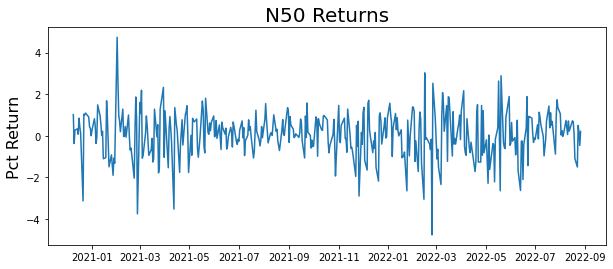

In [4]:
returns = 100 * N50.Close.pct_change().dropna()
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('N50 Returns', fontsize=20)

### **PACF**

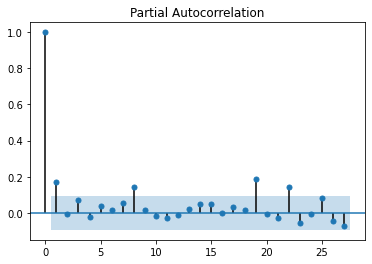

In [5]:
plot_pacf(returns**2)
plt.show()

## **GARCH 1,1**

In [6]:
#use p and q value as 1,0. you may change q, however, as per my experiance choose p=0 to get P>|t| >= 0.05 in volatility model
model = arch_model(returns, p=1, q=0)
model_fit = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1171.2797389283278
Iteration:      2,   Func. Count:     13,   Neg. LLF: 28219.46555736525
Iteration:      3,   Func. Count:     20,   Neg. LLF: 633.7247139347036
Iteration:      4,   Func. Count:     25,   Neg. LLF: 627.3114399833255
Iteration:      5,   Func. Count:     29,   Neg. LLF: 627.271376357678
Iteration:      6,   Func. Count:     33,   Neg. LLF: 627.2701154422894
Iteration:      7,   Func. Count:     37,   Neg. LLF: 627.2700739793651
Iteration:      8,   Func. Count:     41,   Neg. LLF: 627.2700687139309
Iteration:      9,   Func. Count:     44,   Neg. LLF: 627.2700687139339
Optimization terminated successfully    (Exit mode 0)
            Current function value: 627.2700687139309
            Iterations: 9
            Function evaluations: 44
            Gradient evaluations: 9


In [7]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -627.270
Distribution:                  Normal   AIC:                           1260.54
Method:            Maximum Likelihood   BIC:                           1272.70
                                        No. Observations:                  426
Date:                Sun, Aug 28 2022   Df Residuals:                      425
Time:                        11:35:43   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0649  5.422e-02      1.198      0.231 [-4.134e-02,  0.171]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.9616      0.141      6.831  8.421e-12    [  0.686,  1.237]
alpha[1]       0.1616  9.098e-02      1.776  7.578e-02 [-1.676e-02,  0.340]
===========================================================================

Covariance estimator: robust
"""

In [8]:
rolling_predictions = []
test_size = 120

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex=True)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [9]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-120:])

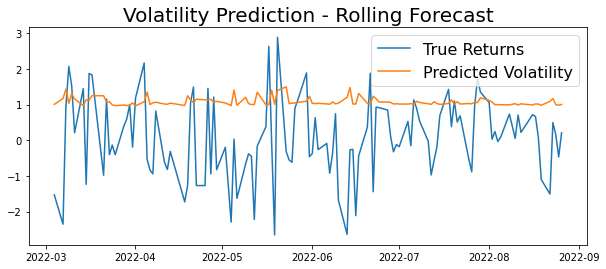

In [10]:
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-120:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

## **NXT 7 DAYS**

In [11]:
train = returns
model = arch_model(train, p=1, q=0)
model_fit = model.fit(disp='off')

In [13]:
pred = model_fit.forecast(horizon=7, reindex=True)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

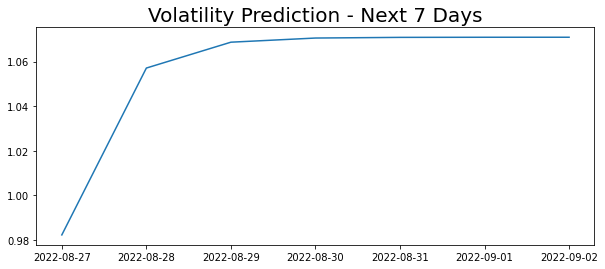

In [14]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)